# This notebook is for the Fair-Shapely experiment

In [48]:
%reload_ext autoreload
%autoreload 2

### 1. Import libraries

In [49]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

### 2. Import dataset

In [50]:
from src.data.unified_dataloader import load_dataset

a, processed_german_credit = load_dataset('german_credit')
# _, processed_uci = load_dataset('uci')

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64


In [51]:
processed_german_credit.head(3)

,Age,sex,Credit amount,Duration,Job_0,Job_1,Job_2,Job_3,Housing_free,Housing_own,...,Checking account_rich,Purpose_business,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Risk
0,2.766456,0,-0.745131,-1.236478,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,-1.191404,1,0.949817,2.248194,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,0,1
2,1.183312,0,-0.416562,-0.738668,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


### 3. Split label/unlabel data, split train/test data.

In [52]:
'''UCI dataset'''
# df = processed_uci.copy()
# X = df.drop('income', axis=1)
# y = df['income']

'''German Credit dataset'''
df = processed_german_credit.copy()
X = df.drop('Risk', axis=1)
y = df['Risk']

# into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=25) 
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (700, 26)
X_test shape: (300, 26)


### 4. Train the original model

In [53]:
model = XGBClassifier()  # 可以替换为 RandomForestClassifier() 等其他模型
model.fit(X_train,y_train)

# 预测和评估
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

Accuracy: 0.6766666666666666


In [54]:
X_train['sex'].value_counts()

sex
0    479
1    221
Name: count, dtype: int64

In [55]:
'''把X_train分成majority和minority两个部分'''

male_condition = X_train['sex'] == 0
X_train_majority = X_train[male_condition]
y_train_majority = y_train[male_condition]

female_condition = X_train['sex'] == 1
X_train_minority = X_train[female_condition]
y_train_minority = y_train[female_condition]

### 5. Evaluate the performance of original model

In [56]:
from src.attribution.oracle_metric import perturb_numpy_ver
from src.attribution import FairnessExplainer
sen_att_name = ["sex"]
sen_att = [X_train.columns.get_loc(name) for name in sen_att_name]
priv_val = [1]
unpriv_dict = [list(set(X_train.values[:, sa])) for sa in sen_att]
for sa_list, pv in zip(unpriv_dict, priv_val):
    sa_list.remove(pv)
# print(f'sen_att_name:{sen_att_name}')
# print(f'sen_att:{sen_att}') # index of sensitive attribute
# print(f'priv_val:{priv_val}') # privileged value
# print(f'unpriv_dict:{unpriv_dict}') # unprivileged value(all values in the sensitive attribute, except the privileged value)



''' 
计算DR value的函数
'''
def fairness_value_function(sen_att, priv_val, unpriv_dict, X, model):
    X_disturbed = perturb_numpy_ver(
        X=X,
        sen_att=sen_att,
        priv_val=priv_val,
        unpriv_dict=unpriv_dict,
        ratio=1.0,
    )
    fx = model.predict_proba(X)[:, 1]
    fx_q = model.predict_proba(X_disturbed)[:, 1]
    return np.mean(np.abs(fx - fx_q))
original_test_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_test.values, model)
print(f'original_test_DR: {original_test_DR}')
original_train_DR = fairness_value_function(sen_att, priv_val, unpriv_dict, X_train.values, model)
print(f'original_train_DR: {original_train_DR}')


original_test_DR: 0.05330166965723038
original_train_DR: 0.044362135231494904


### 5. 把female和male匹配，（或者male和female匹配），然后进行修改，重新训练

2. 初始化FairnessExplainer
3(a). 将X_train_minority_label0与X_train_majority_label0进行匹配
3(b). 将X_train_minority_label1与X_train_majority_label1进行匹配
4(a). 使用fairshap, 从 X_train_majority_label0中找到合适的值替换X_train_minority_label0中的数据
4(b). 使用fairshap, 从 X_train_majority_label1中找到合适的值替换X_train_minority_label1中的数据
5. 计算出varphi和q
shapely value中大于0.1的值的个数有: 8
shapely value中大于0.1的值的个数有: 22


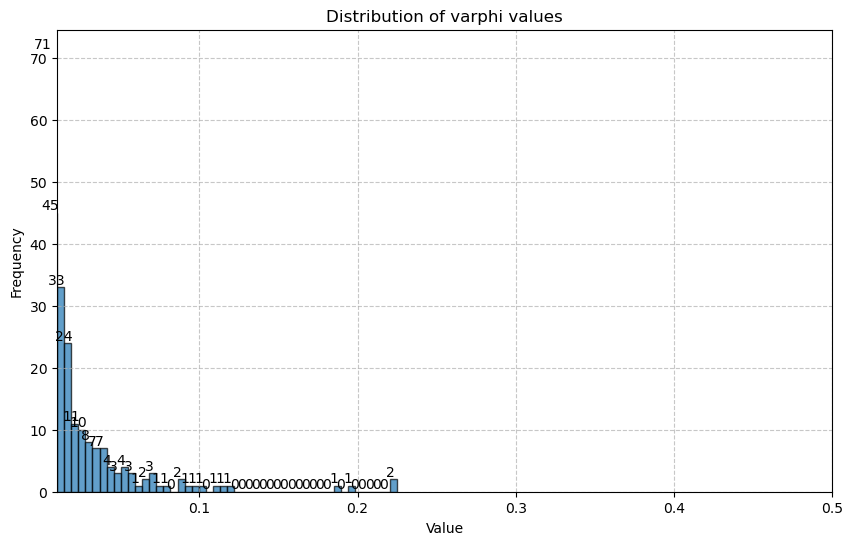

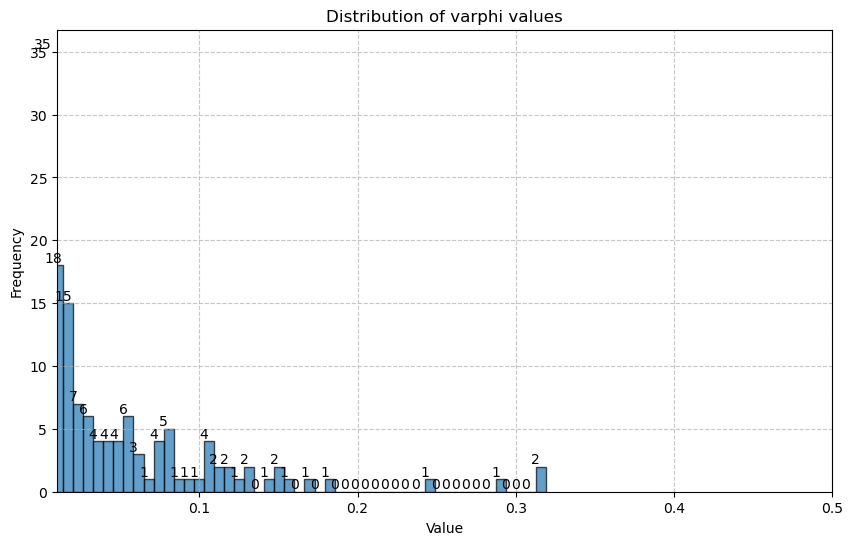

6. 开始整理并且合并新数据,共修改30个数据点, 使用new training set训练新模型
changed_value_info.shape: 29


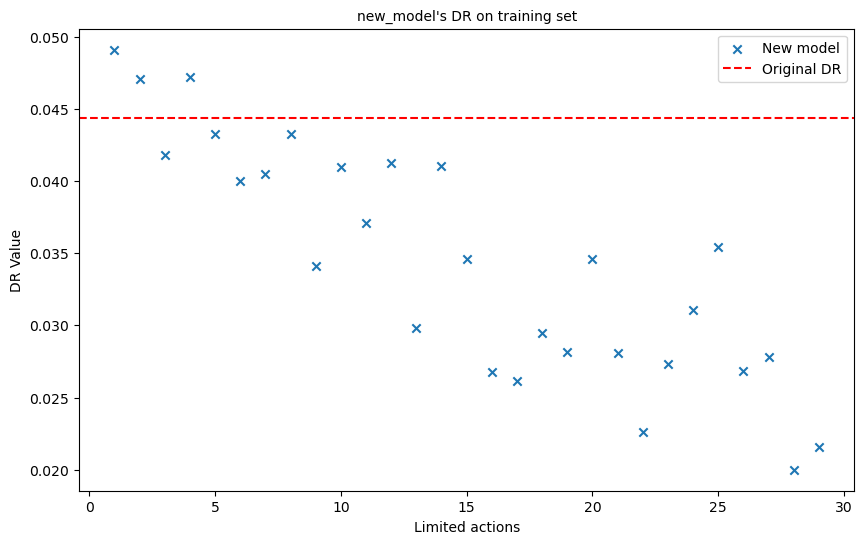

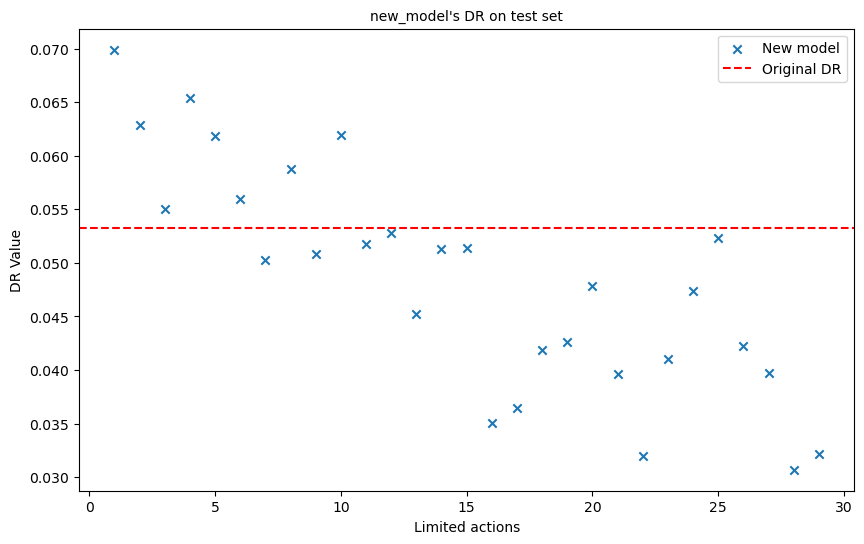

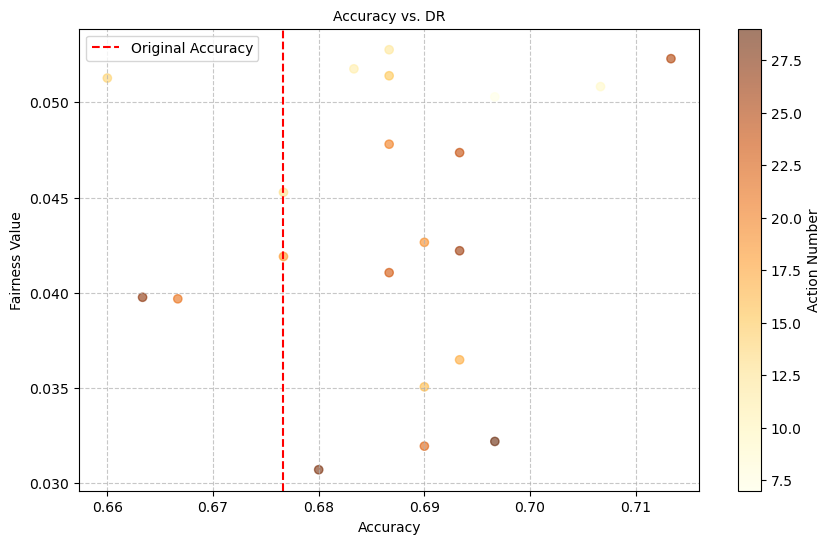

([0.06990323,
  0.062887676,
  0.05500075,
  0.06535748,
  0.061861247,
  0.055983447,
  0.050289832,
  0.058737397,
  0.050828986,
  0.061969962,
  0.051762585,
  0.052767556,
  0.0452752,
  0.051277235,
  0.05139964,
  0.035048682,
  0.03646911,
  0.04189899,
  0.042643934,
  0.04780183,
  0.039674617,
  0.031931594,
  0.041050535,
  0.047360145,
  0.052297764,
  0.042200863,
  0.039755777,
  0.030691821,
  0.03217806],
 [(0.050289832, 0.6966666666666667, 7),
  (0.050828986, 0.7066666666666667, 9),
  (0.051762585, 0.6833333333333333, 11),
  (0.052767556, 0.6866666666666666, 12),
  (0.0452752, 0.6766666666666666, 13),
  (0.051277235, 0.66, 14),
  (0.05139964, 0.6866666666666666, 15),
  (0.035048682, 0.69, 16),
  (0.03646911, 0.6933333333333334, 17),
  (0.04189899, 0.6766666666666666, 18),
  (0.042643934, 0.69, 19),
  (0.04780183, 0.6866666666666666, 20),
  (0.039674617, 0.6666666666666666, 21),
  (0.031931594, 0.69, 22),
  (0.041050535, 0.6866666666666666, 23),
  (0.047360145, 0.69333

In [57]:
from src.experiments_approach2 import ExperimentNew
from src.experiments_approach3 import ExperimentNew2

''' 改变minority group中的部分特征值'''

experiment = ExperimentNew2(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='german_credit',
                            change_group = 'minority')
experiment.run_experiment()


2. 初始化FairnessExplainer
3(a). 将X_train_majority_label0与X_train_minority_label0进行匹配
3(b). 将X_train_majority_label1与X_train_minority_label1进行匹配
4(a). 使用fairshap, 从 X_train_minority_label0中找到合适的值替换X_train_majority_label0中的数据
4(b). 使用fairshap, 从 X_train_minority_label1中找到合适的值替换X_train_majority_label1中的数据
5. 计算出varphi和q
shapely value中大于0.1的值的个数有: 26
shapely value中大于0.1的值的个数有: 15


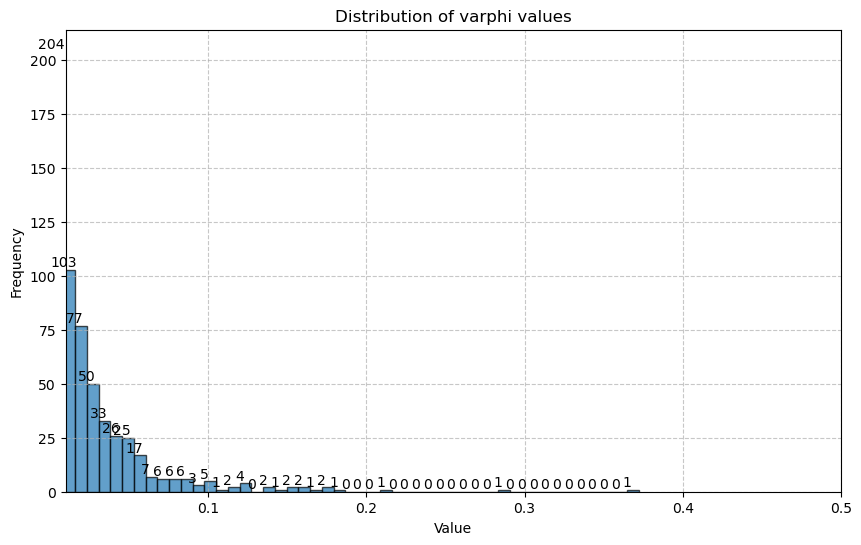

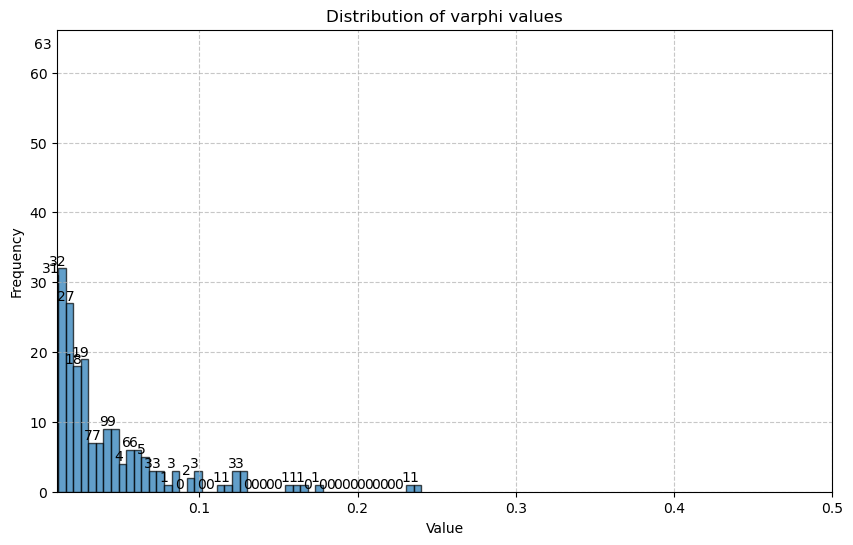

6. 开始整理并且合并新数据,共修改41个数据点, 使用new training set训练新模型
changed_value_info.shape: 40


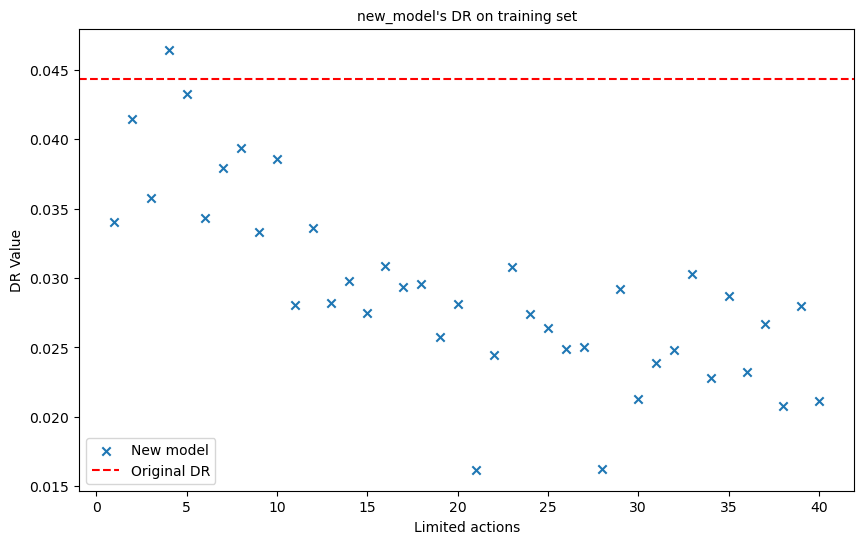

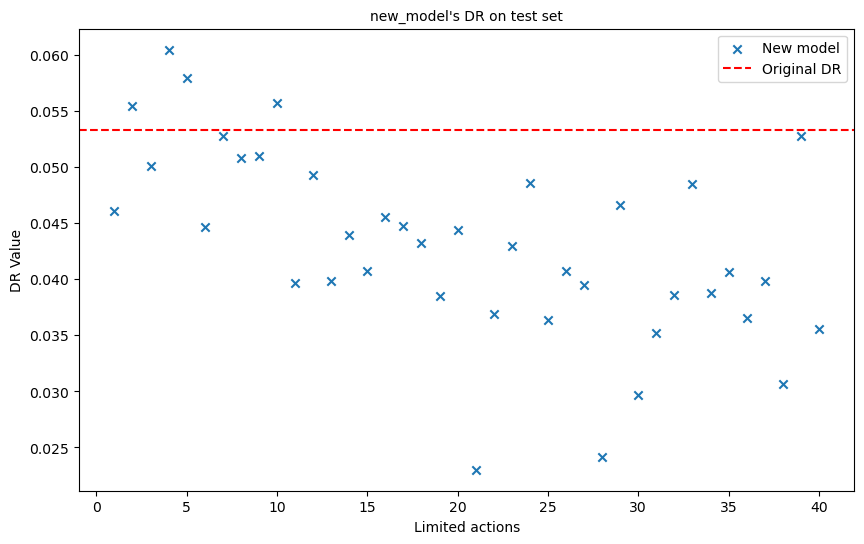

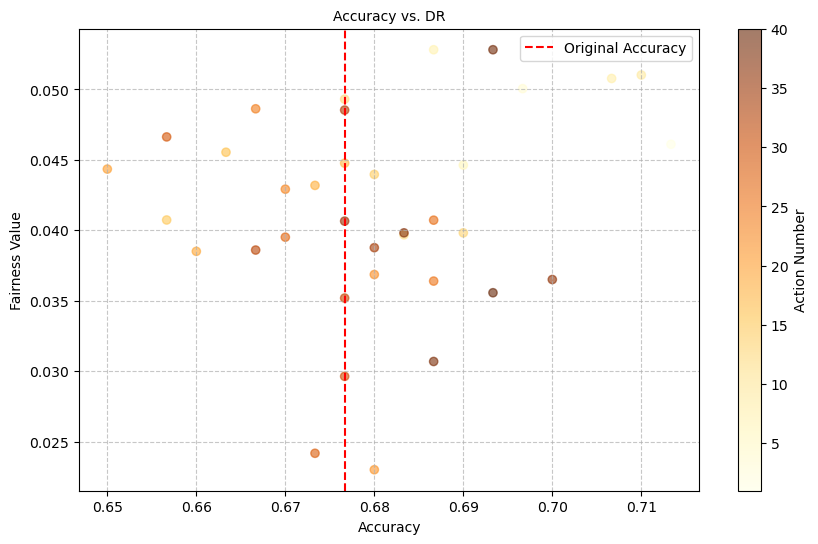

([0.046105765,
  0.055402312,
  0.050054625,
  0.060462125,
  0.057919808,
  0.044629022,
  0.052814104,
  0.05077449,
  0.05102028,
  0.055709444,
  0.039680425,
  0.049306773,
  0.039823074,
  0.04396672,
  0.040735055,
  0.04554212,
  0.04476413,
  0.043188974,
  0.038509548,
  0.044346843,
  0.023017267,
  0.036865626,
  0.04292047,
  0.048624113,
  0.036400605,
  0.04072284,
  0.03951533,
  0.024183746,
  0.046627678,
  0.029641481,
  0.03519617,
  0.038602103,
  0.04853372,
  0.038770773,
  0.04065474,
  0.03651098,
  0.03982184,
  0.030695848,
  0.052814223,
  0.0355735],
 [(0.046105765, 0.7133333333333334, 1),
  (0.050054625, 0.6966666666666667, 3),
  (0.044629022, 0.69, 6),
  (0.052814104, 0.6866666666666666, 7),
  (0.05077449, 0.7066666666666667, 8),
  (0.05102028, 0.71, 9),
  (0.039680425, 0.6833333333333333, 11),
  (0.049306773, 0.6766666666666666, 12),
  (0.039823074, 0.69, 13),
  (0.04396672, 0.68, 14),
  (0.040735055, 0.6566666666666666, 15),
  (0.04554212, 0.66333333333

In [58]:
''' 改变majority group中的部分特征值'''
experiment2 = ExperimentNew2(
                            model,
                            X_train_majority,
                            y_train_majority,
                            X_train_minority,
                            y_train_minority,
                            X_test,
                            y_test,
                            dataset_name='german_credit',
                            change_group = 'majority')
experiment2.run_experiment()

In [59]:
''' Experiment new

1. 从majority parity(此处男性)中随机选择30%, 50%, 70%的比例，作为将被替换的数据集X_train_replace_majority,剩余部分为X_train_rest_majority
2. 将X_train_minority与X_train_replace_majority进行匹配
3. 使用fairshap,把X_train_minority作为baseline dataset，找到X_train_replace_majority中需要替换的数据，假设总共需要替换n个数据点
4. (1,n,20)根据这些,分别计算替换(1,n)中不同个数的结果,把需要替换的数据替换到X_train_replace_majority中,得到X_train_replace_majority_new
5. 把X_train_replace_majority_new和X_train_rest_majority,还有X_train_minority合并,得到新的X_train_new，然后重新训练，得到新的模型model_new，计算新的DR值

----------   循环 30%, 50%, 70%的比例，以及不同的n值，得到DR值的变化  -------------------
'''

' Experiment new\n\n1. 从majority parity(此处男性)中随机选择30%, 50%, 70%的比例，作为将被替换的数据集X_train_replace_majority,剩余部分为X_train_rest_majority\n2. 将X_train_minority与X_train_replace_majority进行匹配\n3. 使用fairshap,把X_train_minority作为baseline dataset，找到X_train_replace_majority中需要替换的数据，假设总共需要替换n个数据点\n4. (1,n,20)根据这些,分别计算替换(1,n)中不同个数的结果,把需要替换的数据替换到X_train_replace_majority中,得到X_train_replace_majority_new\n5. 把X_train_replace_majority_new和X_train_rest_majority,还有X_train_minority合并,得到新的X_train_new，然后重新训练，得到新的模型model_new，计算新的DR值\n\n----------   循环 30%, 50%, 70%的比例，以及不同的n值，得到DR值的变化  -------------------\n'